## Импорты

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib.request
import zipfile
from google.colab import drive
import csv
from itertools import product
from tqdm.auto import tqdm
from datetime import datetime
import time
import numpy as np
import json
import random
import uuid
import csv
from typing import Dict, Any, List, Tuple

## Выгрузка файлов

In [ ]:
drive.mount('/content/drive')
DRIVE_DIV2K_PATH = "/content/drive/MyDrive/DIV2K"
LOCAL_DIV2K_PATH = "/content/DIV2K"
os.makedirs(LOCAL_DIV2K_PATH, exist_ok=True)

def unzip_if_needed(zip_name, extract_to):
    zip_path = os.path.join(DRIVE_DIV2K_PATH, zip_name)
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Файл не найден в Drive: {zip_path}")
    os.makedirs(extract_to, exist_ok=True)
    if not os.listdir(extract_to):
        print(f"Распаковка {zip_name} в {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_to)
        print("Готово!")
    else:
        print(f"Папка {extract_to} уже содержит файлы — пропускаем распаковку.")
unzip_if_needed("DIV2K_train_HR.zip", os.path.join(LOCAL_DIV2K_PATH, "train"))
unzip_if_needed("DIV2K_valid_HR.zip", os.path.join(LOCAL_DIV2K_PATH, "valid"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Распаковка DIV2K_train_HR.zip в /content/DIV2K/train...
Готово!
Распаковка DIV2K_valid_HR.zip в /content/DIV2K/valid...
Готово!


## Датасет

Train samples: 100
Valid samples: 10


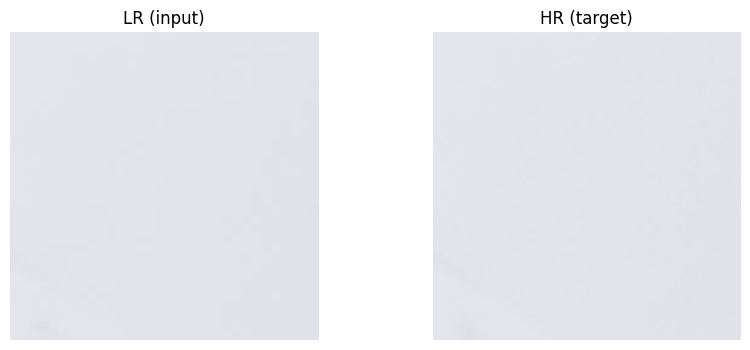

In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, scale=3, patch_size=96, train=True, max_samples = None):
        self.hr_dir = hr_dir
        self.scale = scale
        self.patch_size = patch_size
        self.train = train
        self.filenames = sorted([f for f in os.listdir(hr_dir) if f.endswith(('.png', '.jpg'))])
        if max_samples is not None:
            self.filenames = self.filenames[:max_samples]
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        hr_path = os.path.join(self.hr_dir, self.filenames[idx])
        hr_img = Image.open(hr_path).convert('RGB')

        if self.train:
            w, h = hr_img.size
            w = w // self.scale * self.scale
            h = h // self.scale * self.scale
            hr_img = hr_img.crop((0, 0, w, h))
            hr_patch = transforms.RandomCrop(self.patch_size)(hr_img)
            lr_patch = hr_patch.resize(
                (self.patch_size // self.scale, self.patch_size // self.scale),
                Image.BICUBIC
            )
            hr_tensor = self.transform(hr_patch)
            lr_tensor = self.transform(lr_patch)
        else:
            w, h = hr_img.size
            w = w // self.scale * self.scale
            h = h // self.scale * self.scale
            hr_img = hr_img.crop((0, 0, w, h))
            lr_img = hr_img.resize((w // self.scale, h // self.scale), Image.BICUBIC)
            hr_tensor = self.transform(hr_img)
            lr_tensor = self.transform(lr_img)

        return lr_tensor, hr_tensor

train_dataset = DIV2KDataset("DIV2K/train/DIV2K_train_HR", scale=3, patch_size=96, train=True, max_samples=100)
valid_dataset = DIV2KDataset("DIV2K/valid/DIV2K_valid_HR", scale=3, train=False, max_samples=10)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")

lr_batch, hr_batch = next(iter(train_loader))
lr_img = lr_batch[0].permute(1, 2, 0).numpy()
hr_img = hr_batch[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("LR (input)")
plt.imshow(lr_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("HR (target)")
plt.imshow(hr_img)
plt.axis('off')
plt.show()

# Квантизация

In [ ]:
class LSQQuantizer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, step_size, bit_width=8):
        Qn = -(2 ** (bit_width - 1))
        Qp = (2 ** (bit_width - 1)) - 1
        x_scaled = x / step_size
        x_clamped = torch.clamp(x_scaled, Qn, Qp)
        x_quant = torch.round(x_clamped) * step_size

        ctx.save_for_backward(x, step_size)
        ctx.Qn = Qn
        ctx.Qp = Qp
        return x_quant

    @staticmethod
    def backward(ctx, grad_output):
        x, step_size = ctx.saved_tensors
        Qn, Qp = ctx.Qn, ctx.Qp
        grad_x = grad_output.clone()
        x_scaled = x / step_size
        indicator = (x_scaled >= Qn) & (x_scaled <= Qp)
        grad_step = ((grad_output * torch.sign(x) * indicator).sum()) / (Qp ** 0.5)

        return grad_x, grad_step, None

In [ ]:
class LSQConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 weight_bit=8, act_bit=8, bias=False):
        super().__init__()
        self.weight_bit = weight_bit
        self.act_bit = act_bit
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.weight_step = nn.Parameter(torch.tensor(1e-3))
        self.act_step = nn.Parameter(torch.tensor(1e-3))
        self.quantizer = LSQQuantizer.apply
        self.weight_init = False
        self.act_init = False

    def forward(self, x):
        if not self.weight_init:
            Qp = 2 ** (self.weight_bit - 1) - 1
            std = self.conv.weight.std().item()
            self.weight_step.data = torch.tensor(2 * std / (Qp ** 0.5))
            self.weight_init = True
        w_quant = self.quantizer(self.conv.weight, self.weight_step, self.weight_bit)
        out = F.conv2d(x, w_quant, None, self.conv.stride, self.conv.padding)
        if not self.act_init:
            Qp = 2 ** (self.act_bit - 1) - 1
            std = out.std().item()
            self.act_step.data = torch.tensor(2 * std / (Qp ** 0.5))
            self.act_init = True
        out_quant = self.quantizer(out, self.act_step, self.act_bit)
        return out_quant

In [ ]:
class ESPCN_LSQ(nn.Module):
    def __init__(self, scale_factor=3, num_channels=3, bit_width=8):
        super().__init__()
        self.bit = bit_width
        self.conv1 = LSQConv2d(num_channels, 64, kernel_size=5, padding=2,
                               weight_bit=bit_width, act_bit=bit_width)
        self.conv2 = LSQConv2d(64, 32, kernel_size=3, padding=1,
                               weight_bit=bit_width, act_bit=bit_width)
        self.conv3 = LSQConv2d(32, num_channels * (scale_factor ** 2), kernel_size=3, padding=1,
                               weight_bit=bit_width, act_bit=bit_width)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pixel_shuffle(self.conv3(x))
        return x

In [ ]:
def calculate_psnr(img1, img2):
    """PSNR метрика для тензоров."""
    mse = torch.mean((img1 - img2) ** 2)
    return 20. * torch.log10(1.0 / torch.sqrt(mse))

# Проверка работы LSQ-квантизации

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ESPCN_LSQ(scale_factor=3, bit_width=8).to(device)
model.train()

lr_batch, hr_batch = next(iter(train_loader))
lr_batch = lr_batch.to(device)

with torch.no_grad():
    output = model(lr_batch)
print("Output shape:", output.shape)

Output shape: torch.Size([4, 3, 96, 96])


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}, shape={param.shape}")

conv1.weight_step: requires_grad=True, shape=torch.Size([])
conv1.act_step: requires_grad=True, shape=torch.Size([])
conv1.conv.weight: requires_grad=True, shape=torch.Size([64, 3, 5, 5])
conv2.weight_step: requires_grad=True, shape=torch.Size([])
conv2.act_step: requires_grad=True, shape=torch.Size([])
conv2.conv.weight: requires_grad=True, shape=torch.Size([32, 64, 3, 3])
conv3.weight_step: requires_grad=True, shape=torch.Size([])
conv3.act_step: requires_grad=True, shape=torch.Size([])
conv3.conv.weight: requires_grad=True, shape=torch.Size([27, 32, 3, 3])


In [ ]:
initial_steps = {}
for name, param in model.named_parameters():
    if 'step' in name:
        initial_steps[name] = param.item()

lr_batch, hr_batch = next(iter(train_loader))
lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

output = model(lr_batch)
loss = criterion(output, hr_batch)
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Изменение step_size после одного шага:")
for name, param in model.named_parameters():
    if 'step' in name:
        delta = param.item() - initial_steps[name]
        print(f"{name}: {initial_steps[name]:.6f} → {param.item():.6f} (Δ = {delta:.2e})")

Изменение step_size после одного шага:
conv1.weight_step: 0.011786 → 0.012786 (Δ = 1.00e-03)
conv1.act_step: 0.036528 → 0.037528 (Δ = 1.00e-03)
conv2.weight_step: 0.004275 → 0.005275 (Δ = 1.00e-03)
conv2.act_step: 0.012028 → 0.013028 (Δ = 1.00e-03)
conv3.weight_step: 0.006084 → 0.007084 (Δ = 1.00e-03)
conv3.act_step: 0.005253 → 0.006253 (Δ = 1.00e-03)


In [ ]:
w_orig = model.conv1.conv.weight.data.clone()
w_quant = model.conv1.quantizer(w_orig, model.conv1.weight_step, model.conv1.weight_bit)

print("Original weight (mean):", w_orig.mean().item())
print("Quantized weight (mean):", w_quant.mean().item())
print("Differnt:", not torch.allclose(w_orig, w_quant, atol=1e-6))

Original weight (mean): -0.0012463727034628391
Quantized weight (mean): -0.0012812204658985138
Differnt: True


In [ ]:
optimizer.zero_grad()
output = model(lr_batch)
loss = criterion(output, hr_batch)
loss.backward()

for name, param in model.named_parameters():
    if 'step' in name:
        grad = param.grad
        print(f"{name} grad: {grad.item() if grad is not None else 'None'}")

conv1.weight_step grad: -0.04386701434850693
conv1.act_step grad: -0.013907056301832199
conv2.weight_step grad: -0.09416934847831726
conv2.act_step grad: -0.0290095005184412
conv3.weight_step grad: -0.08264689892530441
conv3.act_step grad: -0.05065440014004707


In [ ]:
def train_and_log(
    model_class, optimizer_class, optimizer_kwargs, batch_size, epochs,
    run_id, experiment_root, scale=3, bit_width=8, device=device
):
    train_dataset = DIV2KDataset("/content/DIV2K/train/DIV2K_train_HR", scale=scale, train=True)
    valid_dataset = DIV2KDataset("/content/DIV2K/valid/DIV2K_valid_HR", scale=scale, train=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

    model = model_class(scale_factor=scale, bit_width=bit_width).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_kwargs)
    criterion = nn.L1Loss()

    all_val_psnrs = []
    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_psnr': []}

    print(f"\nЗапуск {run_id} | bs={batch_size}, lr={optimizer_kwargs['lr']:.0e} | эпох: {epochs}")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{epochs}", leave=False)
        for lr_img, hr_img in pbar:
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            sr_img = model(lr_img)
            loss = criterion(sr_img, hr_img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_psnr, val_loss = 0.0, 0.0
        with torch.no_grad():
            for lr_img, hr_img in valid_loader:
                lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                sr_img = model(lr_img)
                val_loss += criterion(sr_img, hr_img).item()
                val_psnr += calculate_psnr(sr_img, hr_img).item()
        val_psnr /= len(valid_loader)
        val_loss /= len(valid_loader)

        all_val_psnrs.append(val_psnr)
        history['epoch'].append(epoch+1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_psnr'].append(val_psnr)

        epoch_time = time.time() - epoch_start
        elapsed = time.time() - start_time
        eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
        print(f"  → Эпоха {epoch+1}: loss={train_loss:.4f}, PSNR={val_psnr:.2f} dB "
              f"| время: {epoch_time:.1f}s | ETA: {eta/60:.1f} мин")

    total_time = time.time() - start_time
    print(f"Завершено за {total_time/60:.1f} мин.")
    lr = optimizer_kwargs['lr']
    prefix = f"{OPTIMIZER_NAME}_bs{batch_size}_lr{lr:.0e}_run{run_id}"
    log_path = os.path.join(experiment_root, "logs", f"{prefix}.csv")
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'val_loss', 'val_psnr'])
        for i in range(len(history['epoch'])):
            writer.writerow([history['epoch'][i], history['train_loss'][i], history['val_loss'][i], history['val_psnr'][i]])
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['val_psnr'], label='Val PSNR', color='green')
    plt.xlabel('Epoch'); plt.ylabel('PSNR (dB)'); plt.legend(); plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(experiment_root, "plots", f"{prefix}.png"))
    plt.close()

    return all_val_psnrs

# Оптимизаторы


In [2]:
import torch

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import random
import uuid
import time
import json
import csv
import matplotlib.pyplot as plt
from typing import Dict, Any, List, Tuple
from google.colab import drive
drive.mount('/content/drive')
DIV2K_TRAIN_DIR = '/content/DIV2K/train/DIV2K_train_HR'
DIV2K_VALID_DIR = '/content/DIV2K/valid/DIV2K_valid_HR'
EXPERIMENT_ROOT = "/content/drive/MyDrive/SR_ESPCN_LSQ_Experiments"
TASK_NAME = "SuperResolution"
SEEDS = [21, 42, 101, 77, 123, 500, 601, 802, 903, 1004]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
batch_sizes = [8, 16]
learning_rates = [1e-4, 5e-4, 1e-3]
EPOCHS = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_and_get_history(
    ModelClass: Any,
    OptimizerClass: Any,
    opt_params: Dict[str, Any],
    batch_size: int,
    epochs: int,
    seed: int,
    device: torch.device,
    log_path: str = None
) -> Tuple[List[float], List[float]]:
    """Выполняет обучение и возвращает историю PSNR и потерь."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    model = ModelClass(scale_factor=3, bit_width=8).to(device)
    optimizer = OptimizerClass(model.parameters(), **opt_params)
    criterion = nn.MSELoss()
    train_dataset = DIV2KDataset("DIV2K/train/DIV2K_train_HR", scale=3, patch_size=96, train=True, max_samples=100)
    valid_dataset = DIV2KDataset("DIV2K/valid/DIV2K_valid_HR", scale=3, train=False, max_samples=10)

    if len(train_dataset) == 0 or len(valid_dataset) == 0:
        return [], []

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

    psnr_history = []
    loss_history = []

    log_writer = None
    if log_path:
        log_file = open(log_path, 'w', newline='')
        log_writer = csv.writer(log_file)
        log_writer.writerow(['epoch', 'train_loss', 'val_psnr'])

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for lr, hr in train_loader:
            lr, hr = lr.to(device), hr.to(device)
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * lr.size(0)

        avg_loss = total_loss / len(train_dataset)
        loss_history.append(avg_loss)
        model.eval()
        total_psnr = 0
        with torch.no_grad():
            for lr, hr in valid_loader:
                lr, hr = lr.to(device), hr.to(device)
                sr = model(lr)
                sr_cropped = sr[..., 6:-6, 6:-6]
                hr_cropped = hr[..., 6:-6, 6:-6]

                total_psnr += calculate_psnr(sr_cropped, hr_cropped).item()

        avg_psnr = total_psnr / len(valid_dataset)
        psnr_history.append(avg_psnr)

        print(f"  [Эпоха {epoch}/{epochs}] Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB")

        if log_writer:
            log_writer.writerow([epoch, avg_loss, avg_psnr])
            log_file.flush()

    if log_writer:
        log_file.close()

    return psnr_history, loss_history

In [ ]:
def run_single_experiment(
    task_name: str,
    optimizer_name: str,
    batch_size: int,
    learning_rate: float,
    epochs: int,
    seed: int,
    log_file_path: str,
    ModelClass: Any,
    OptimizerClass: Any,
    device: torch.device,
    opt_params_extra: Dict[str, Any] = None # Добавлен аргумент для extra params
) -> Dict[str, Any]:
    """Выполняет один полный цикл обучения и возвращает словарь с результатами."""
    start_time = time.time()
    run_id = str(uuid.uuid4())

    print(f"\nЗапуск (BS={batch_size}, LR={learning_rate:.1e}, Seed={seed})")

    # Подготовка параметров оптимизатора
    opt_params = {"lr": learning_rate}
    if opt_params_extra:
        opt_params.update(opt_params_extra)

    metric_history, loss_history = train_and_get_history(
        ModelClass=ModelClass,
        OptimizerClass=OptimizerClass,
        opt_params=opt_params,
        batch_size=batch_size,
        epochs=epochs,
        seed=seed,
        device=device,
        log_path=log_file_path
    )
    if not metric_history:
        return {}

    best_metric = max(metric_history)
    best_epoch = metric_history.index(best_metric) + 1
    final_metric = metric_history[-1]
    mean_metric = np.mean(metric_history)

    end_time = time.time()
    total_time_sec = round(end_time - start_time, 2)

    results = {
        'run_id': run_id,
        'task_name': task_name,
        'model_name': 'ESPCN_LSQ',
        'optimizer': optimizer_name,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'seed': seed,
        'log_file_path': log_file_path,
        'mean_metric_all_epochs': float(mean_metric),
        'best_metric': float(best_metric),
        'best_epoch': best_epoch,
        'final_metric': float(final_metric),
        'total_time_sec': total_time_sec,
        'metric_history': [float(m) for m in metric_history],
        'loss_history': [float(l) for l in loss_history],
    }
    return results

## Adam

In [ ]:
OPTIMIZER_NAME = "Adam"

In [ ]:
OptimizerClass = torch.optim.Adam
opt_params_extra = {}

OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2564, PSNR: 6.90 dB
  [Эпоха 2/6] Loss: 0.1827, PSNR: 8.87 dB
  [Эпоха 3/6] Loss: 0.1088, PSNR: 12.86 dB
  [Эпоха 4/6] Loss: 0.0507, PSNR: 13.92 dB
  [Эпоха 5/6] Loss: 0.0321, PSNR: 17.32 dB
  [Эпоха 6/6] Loss: 0.0271, PSNR: 17.43 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 17.43 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.1917, PSNR: 6.73 dB
  [Эпоха 2/6] Loss: 0.1858, PSNR: 8.49 dB
  [Эпоха 3/6] Loss: 0.1269, PSNR: 12.64 dB
  [Эпоха 4/6] Loss: 0.0475, PSNR: 14.98 dB
  [Эпоха 5/6] Loss: 0.0291, PSNR: 17.27 dB
  [Эпоха 6/6] Loss: 0.0249, PSNR: 17.93 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 17.93 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2523, PSNR: 6.67 dB
  [Эпоха 2/6] Loss: 0.2064, PSNR: 8.20 dB
  [Эпоха 3/6] Loss: 0.1310, PSNR: 11.66 dB
  [Эпоха 4/6] Loss: 0.0600, PSNR: 13.61 dB
  [Эпоха 5/6] Loss: 0.0358, PSNR: 16.58 dB
  [Эпоха 6/6] Loss: 0.0258, PSNR: 17.34 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 17.34 dB

Запуск (BS=8, LR=1.0e-

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")


✅ Все результаты сохранены в ALL_RESULTS_Adam_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)  # key: (bs, lr) → list of mean_metric

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ: BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ: BS=8, LR=1e-03 → Средний PSNR = 18.78 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

In [ ]:
final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")

summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (Adam): PSNR = 21.34 ± 0.29 dB


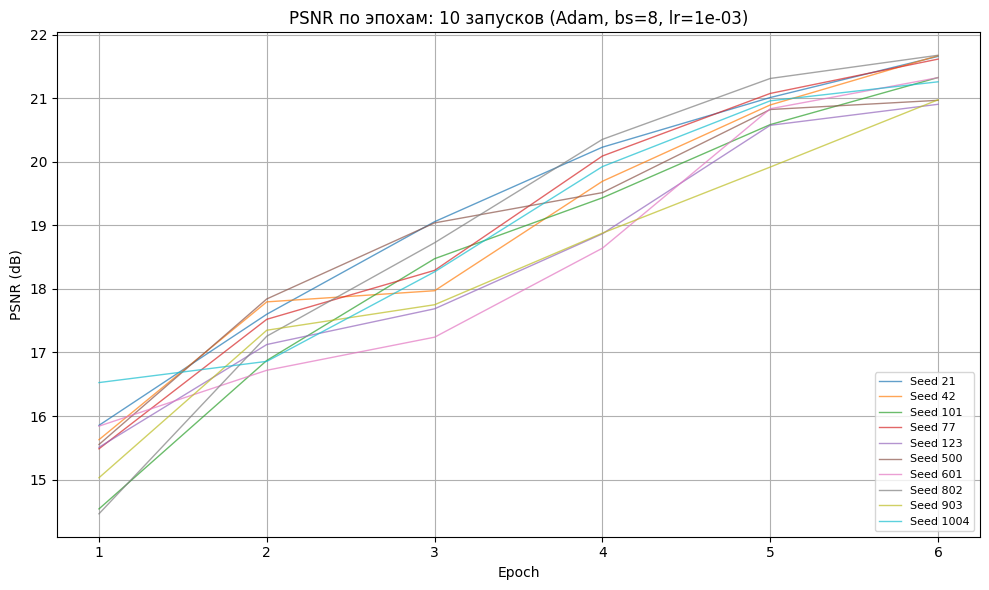

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

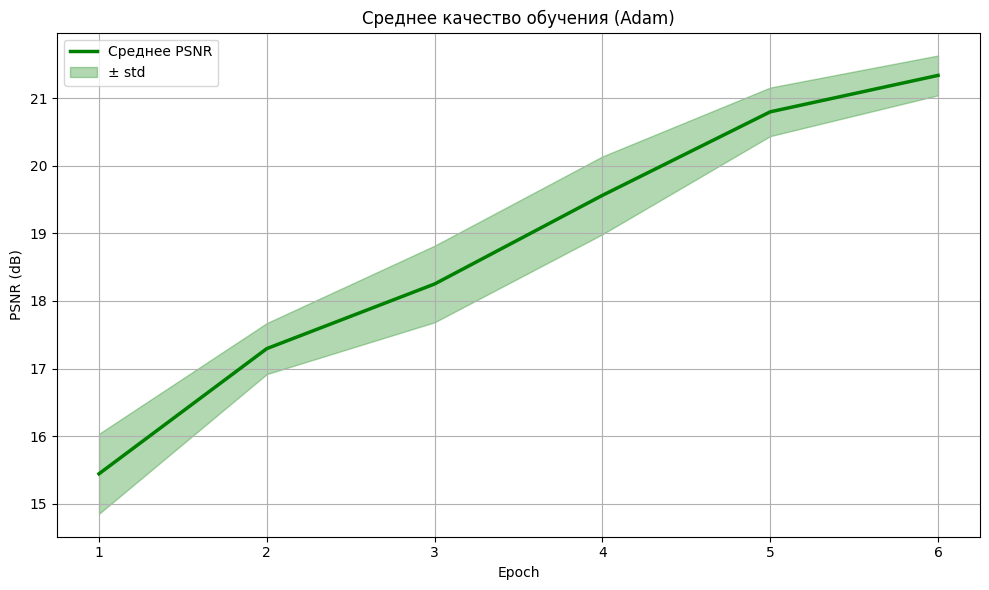

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

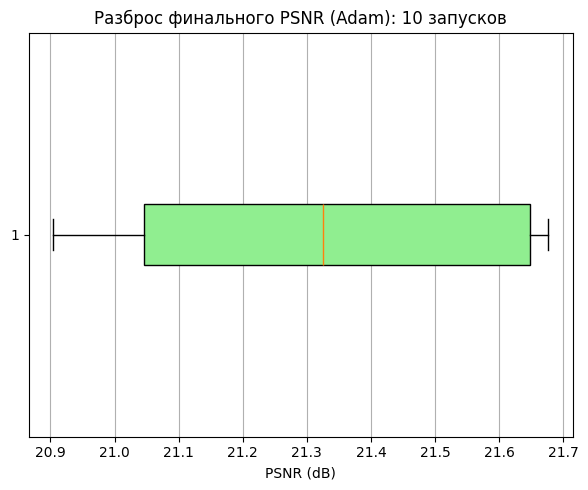

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

## SGD


In [ ]:
OPTIMIZER_NAME = "SGD"

In [ ]:
OptimizerClass = torch.optim.SGD
opt_params_extra = {"momentum": 0.9}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2787, PSNR: 5.96 dB
  [Эпоха 2/6] Loss: 0.2581, PSNR: 6.00 dB
  [Эпоха 3/6] Loss: 0.2863, PSNR: 6.05 dB
  [Эпоха 4/6] Loss: 0.2773, PSNR: 6.11 dB
  [Эпоха 5/6] Loss: 0.2673, PSNR: 6.15 dB
  [Эпоха 6/6] Loss: 0.2428, PSNR: 6.15 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 6.15 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.2042, PSNR: 5.99 dB
  [Эпоха 2/6] Loss: 0.2475, PSNR: 6.02 dB
  [Эпоха 3/6] Loss: 0.2888, PSNR: 6.05 dB
  [Эпоха 4/6] Loss: 0.2750, PSNR: 6.08 dB
  [Эпоха 5/6] Loss: 0.2316, PSNR: 6.11 dB
  [Эпоха 6/6] Loss: 0.2154, PSNR: 6.13 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 6.13 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2643, PSNR: 6.07 dB
  [Эпоха 2/6] Loss: 0.2561, PSNR: 6.09 dB
  [Эпоха 3/6] Loss: 0.2612, PSNR: 6.10 dB
  [Эпоха 4/6] Loss: 0.2496, PSNR: 6.11 dB
  [Эпоха 5/6] Loss: 0.2355, PSNR: 6.14 dB
  [Эпоха 6/6] Loss: 0.2443, PSNR: 6.17 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 6.17 dB

Запуск (BS=8, LR=1.0e-04, Seed=77)
  

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")


✅ Все результаты сохранены в ALL_RESULTS_SGD_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (SGD): BS=8, LR=1e-03 → Средний PSNR = 7.38 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (SGD): PSNR = 9.43 ± 1.68 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


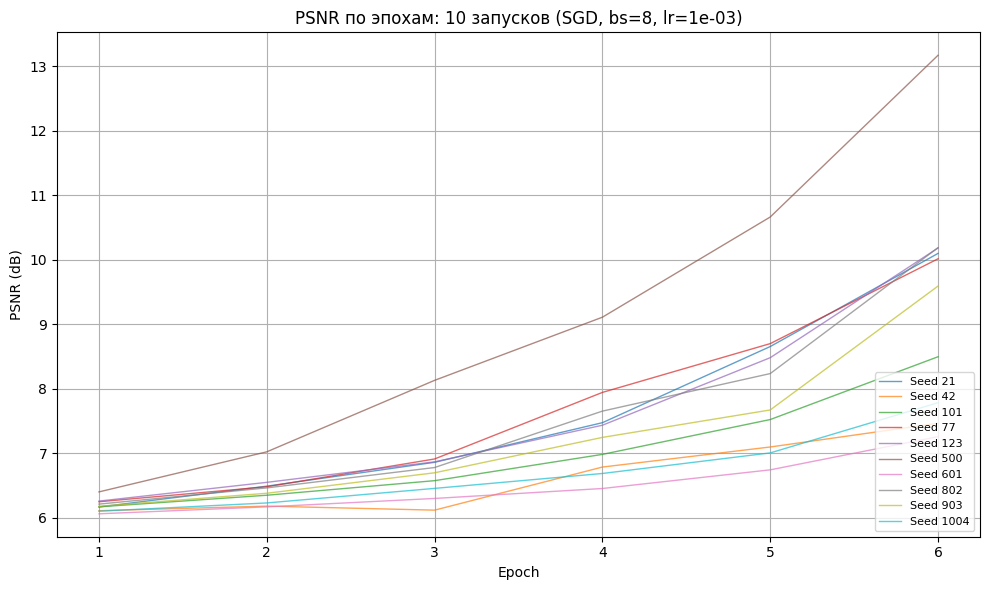

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

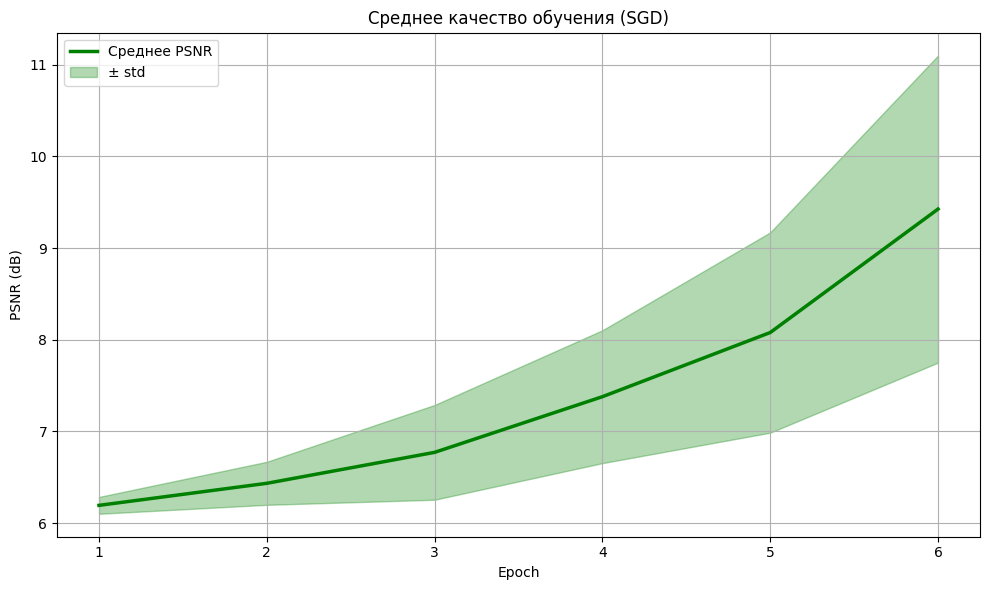

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

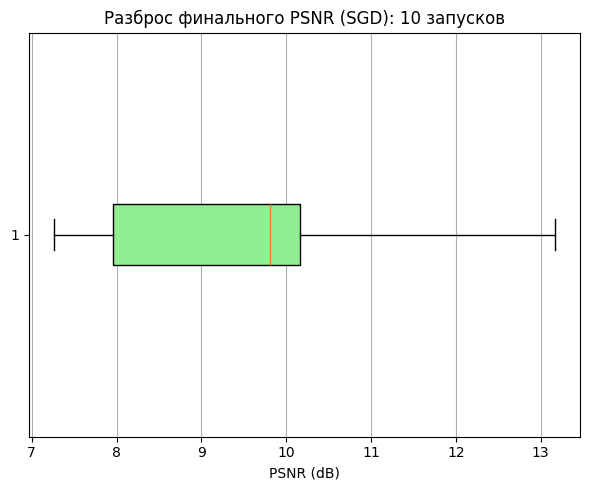


Эксперимент для SGD завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## Nesterov Momentum


In [ ]:
OPTIMIZER_NAME = "Nesterov"

In [ ]:
OptimizerClass = torch.optim.SGD
opt_params_extra = {"momentum": 0.9, "nesterov": True}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2786, PSNR: 5.96 dB
  [Эпоха 2/6] Loss: 0.2579, PSNR: 6.00 dB
  [Эпоха 3/6] Loss: 0.2861, PSNR: 6.05 dB
  [Эпоха 4/6] Loss: 0.2771, PSNR: 6.11 dB
  [Эпоха 5/6] Loss: 0.2673, PSNR: 6.15 dB
  [Эпоха 6/6] Loss: 0.2430, PSNR: 6.16 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 6.16 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.2041, PSNR: 6.00 dB
  [Эпоха 2/6] Loss: 0.2474, PSNR: 6.02 dB
  [Эпоха 3/6] Loss: 0.2888, PSNR: 6.05 dB
  [Эпоха 4/6] Loss: 0.2748, PSNR: 6.08 dB
  [Эпоха 5/6] Loss: 0.2315, PSNR: 6.11 dB
  [Эпоха 6/6] Loss: 0.2153, PSNR: 6.13 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 6.13 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2642, PSNR: 6.08 dB
  [Эпоха 2/6] Loss: 0.2560, PSNR: 6.09 dB
  [Эпоха 3/6] Loss: 0.2612, PSNR: 6.10 dB
  [Эпоха 4/6] Loss: 0.2495, PSNR: 6.11 dB
  [Эпоха 5/6] Loss: 0.2355, PSNR: 6.14 dB
  [Эпоха 6/6] Loss: 0.2442, PSNR: 6.17 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 6.17 dB

Запуск (BS=8, LR=1.0e-04, Seed=77)
  

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\n Все результаты сохранены в {search_results_filename}.")


 Все результаты сохранены в ALL_RESULTS_Nesterov_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (Nesterov): BS=8, LR=1e-03 → Средний PSNR = 7.57 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (Nesterov): PSNR = 10.06 ± 1.78 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


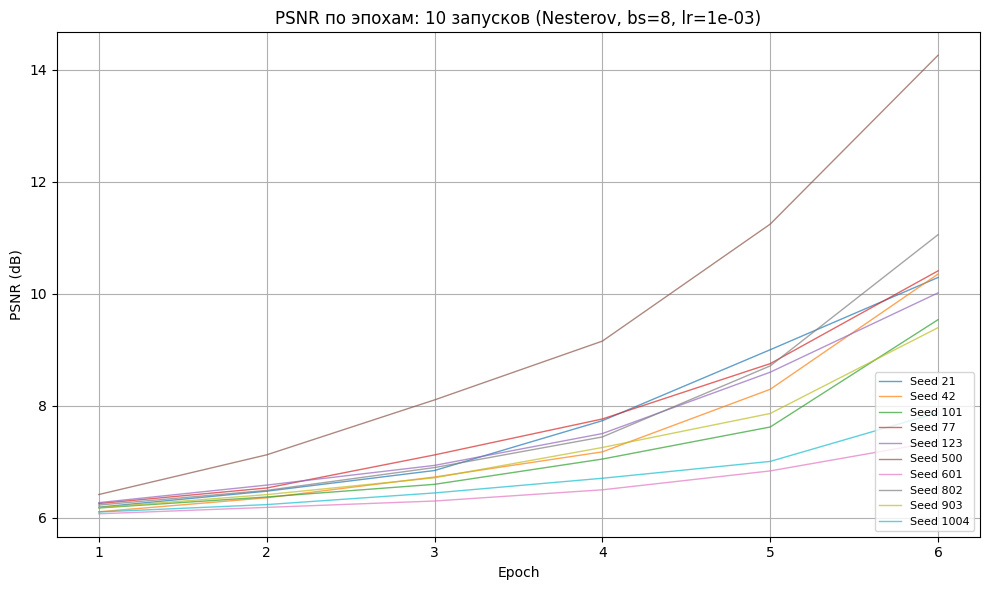

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

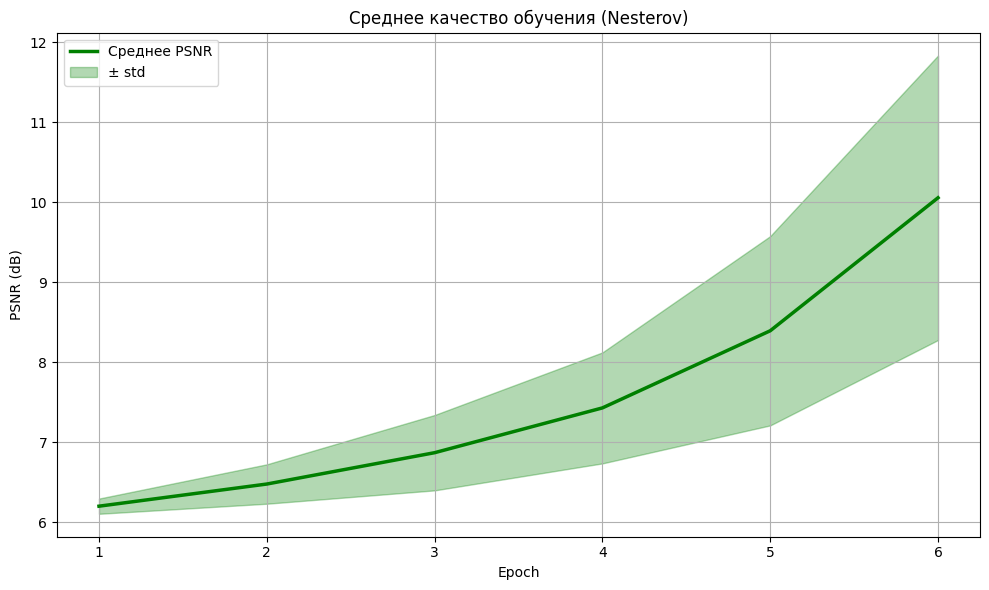

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

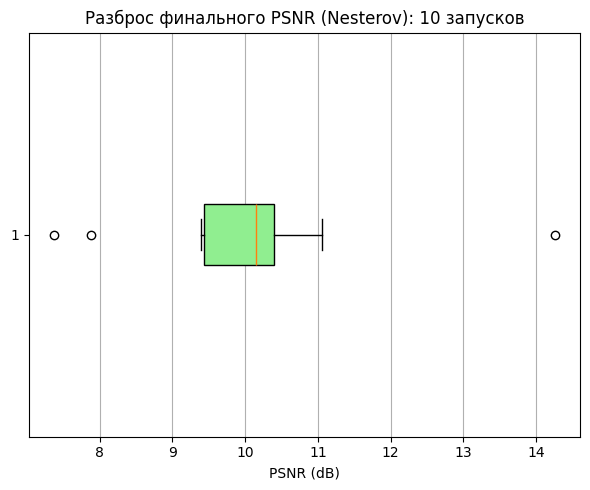


Эксперимент для Nesterov завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## AdaGrad

In [ ]:
OPTIMIZER_NAME = "AdaGrad"

In [ ]:
OptimizerClass = torch.optim.Adagrad
opt_params_extra = {}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2661, PSNR: 6.38 dB
  [Эпоха 2/6] Loss: 0.2314, PSNR: 6.66 dB
  [Эпоха 3/6] Loss: 0.2444, PSNR: 6.88 dB
  [Эпоха 4/6] Loss: 0.2297, PSNR: 7.11 dB
  [Эпоха 5/6] Loss: 0.2086, PSNR: 7.49 dB
  [Эпоха 6/6] Loss: 0.1770, PSNR: 7.83 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 7.83 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.1956, PSNR: 6.31 dB
  [Эпоха 2/6] Loss: 0.2264, PSNR: 6.59 dB
  [Эпоха 3/6] Loss: 0.2497, PSNR: 6.87 dB
  [Эпоха 4/6] Loss: 0.2236, PSNR: 7.17 dB
  [Эпоха 5/6] Loss: 0.1800, PSNR: 7.38 dB
  [Эпоха 6/6] Loss: 0.1602, PSNR: 7.67 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 7.67 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2574, PSNR: 6.32 dB
  [Эпоха 2/6] Loss: 0.2386, PSNR: 6.55 dB
  [Эпоха 3/6] Loss: 0.2327, PSNR: 6.77 dB
  [Эпоха 4/6] Loss: 0.2118, PSNR: 7.00 dB
  [Эпоха 5/6] Loss: 0.1910, PSNR: 7.24 dB
  [Эпоха 6/6] Loss: 0.1888, PSNR: 7.48 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 7.48 dB

Запуск (BS=8, LR=1.0e-04, Seed=77)
  

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")


Все результаты сохранены в ALL_RESULTS_AdaGrad_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (AdaGrad): BS=8, LR=1e-03 → Средний PSNR = 18.68 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (AdaGrad): PSNR = 19.73 ± 0.48 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


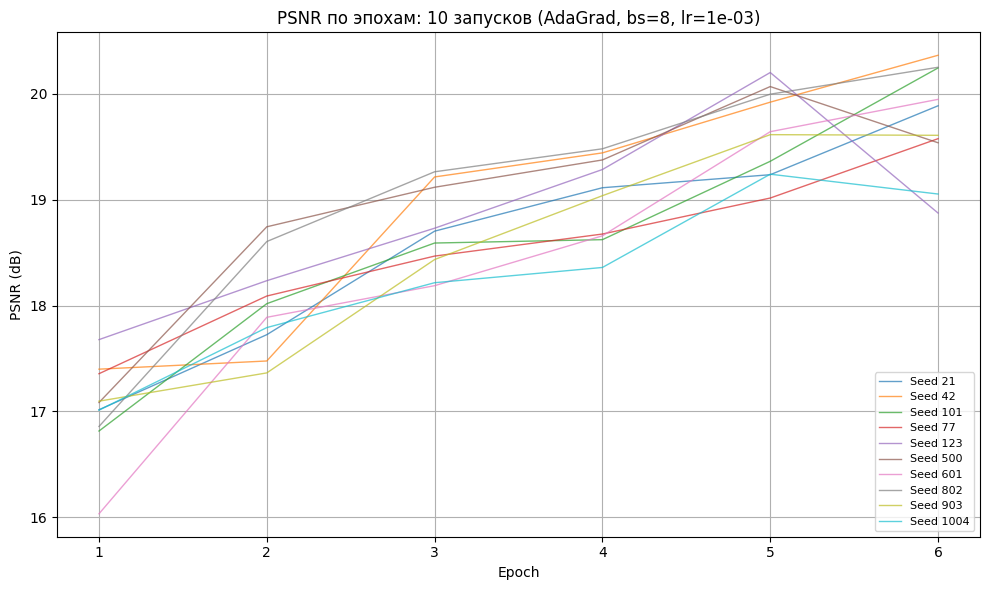

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

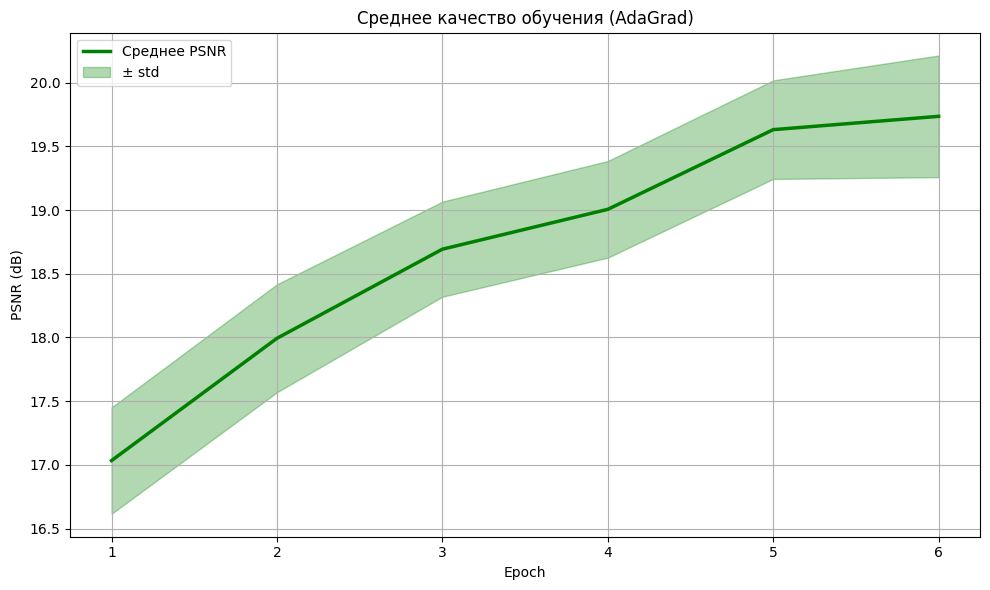

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

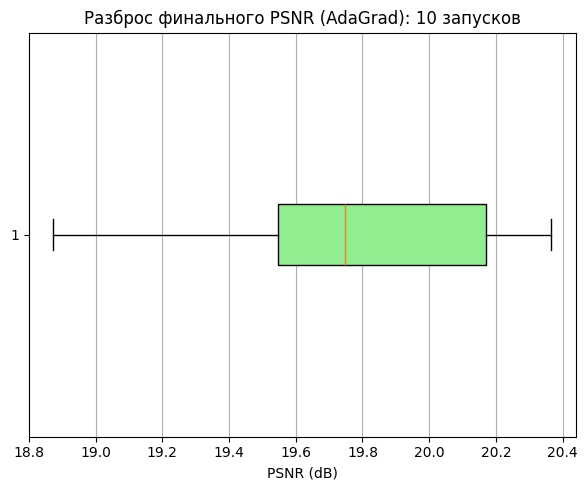


Эксперимент для AdaGrad завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## RMSprop


In [ ]:
OPTIMIZER_NAME = "RMSprop"

In [ ]:
OptimizerClass = torch.optim.RMSprop
opt_params_extra = {"alpha": 0.99}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.1115, PSNR: 17.05 dB
  [Эпоха 2/6] Loss: 0.0255, PSNR: 17.78 dB
  [Эпоха 3/6] Loss: 0.0220, PSNR: 18.62 dB
  [Эпоха 4/6] Loss: 0.0191, PSNR: 19.25 dB
  [Эпоха 5/6] Loss: 0.0170, PSNR: 19.43 dB
  [Эпоха 6/6] Loss: 0.0161, PSNR: 19.92 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 19.92 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.0797, PSNR: 17.41 dB
  [Эпоха 2/6] Loss: 0.0243, PSNR: 17.87 dB
  [Эпоха 3/6] Loss: 0.0236, PSNR: 19.20 dB
  [Эпоха 4/6] Loss: 0.0192, PSNR: 19.50 dB
  [Эпоха 5/6] Loss: 0.0156, PSNR: 20.09 dB
  [Эпоха 6/6] Loss: 0.0151, PSNR: 20.59 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 20.59 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.1107, PSNR: 16.87 dB
  [Эпоха 2/6] Loss: 0.0284, PSNR: 18.00 dB
  [Эпоха 3/6] Loss: 0.0234, PSNR: 18.75 dB
  [Эпоха 4/6] Loss: 0.0192, PSNR: 19.51 dB
  [Эпоха 5/6] Loss: 0.0164, PSNR: 19.40 dB
  [Эпоха 6/6] Loss: 0.0141, PSNR: 20.17 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 20.17 dB

Запуск (BS=8, LR

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")


Все результаты сохранены в ALL_RESULTS_RMSprop_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (RMSprop): BS=8, LR=1e-04 → Средний PSNR = 18.78 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (RMSprop): PSNR = 19.97 ± 0.31 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


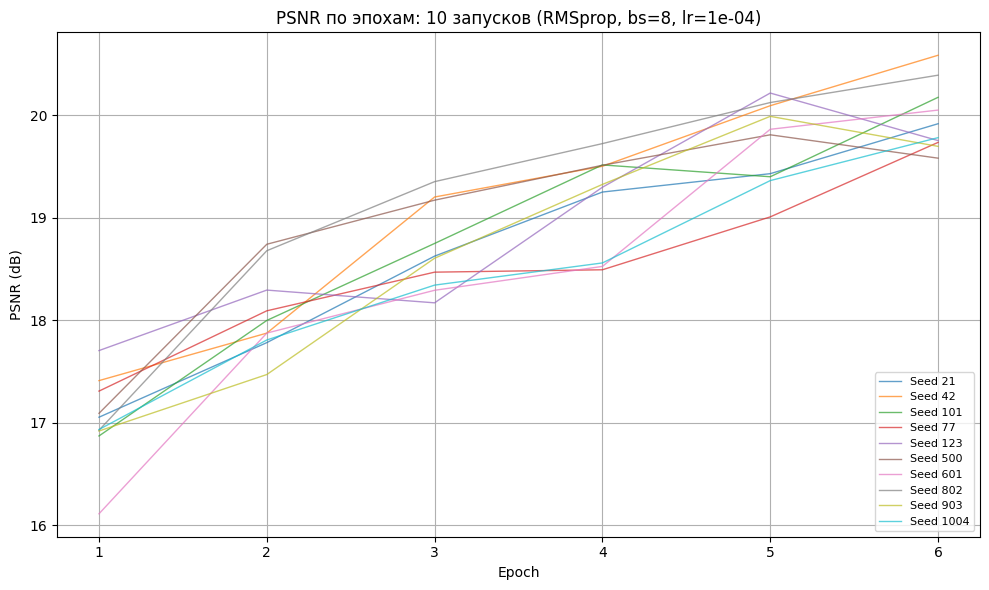

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

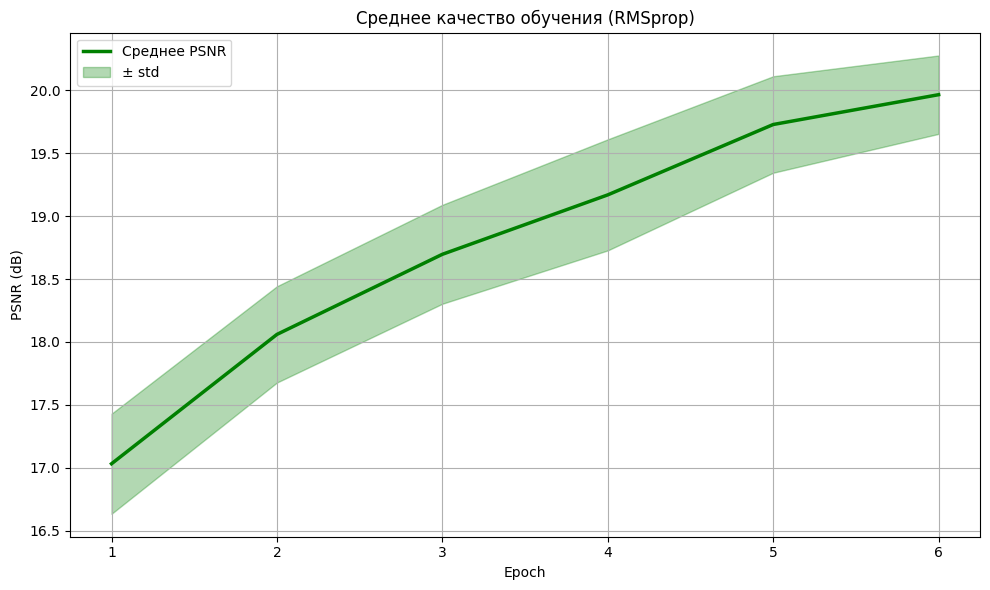

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

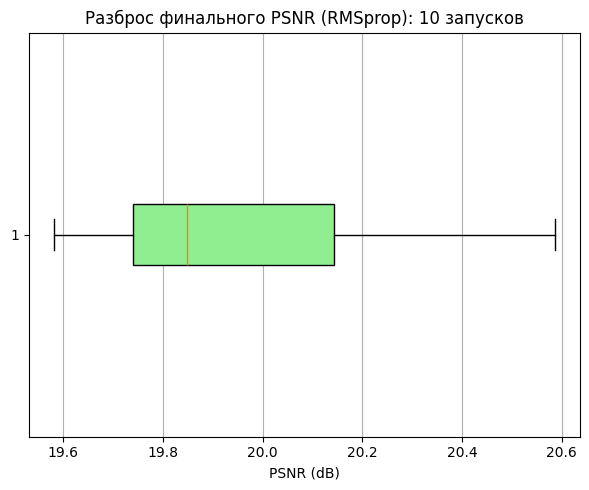


Эксперимент для RMSprop завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## AdamW


In [ ]:
OPTIMIZER_NAME = "AdamW"

In [ ]:
OptimizerClass = torch.optim.AdamW
opt_params_extra = {"weight_decay": 1e-4}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2564, PSNR: 6.90 dB
  [Эпоха 2/6] Loss: 0.1827, PSNR: 8.87 dB
  [Эпоха 3/6] Loss: 0.1088, PSNR: 12.86 dB
  [Эпоха 4/6] Loss: 0.0507, PSNR: 13.92 dB
  [Эпоха 5/6] Loss: 0.0321, PSNR: 17.32 dB
  [Эпоха 6/6] Loss: 0.0271, PSNR: 17.43 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 17.43 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.1917, PSNR: 6.73 dB
  [Эпоха 2/6] Loss: 0.1858, PSNR: 8.49 dB
  [Эпоха 3/6] Loss: 0.1269, PSNR: 12.64 dB
  [Эпоха 4/6] Loss: 0.0475, PSNR: 14.98 dB
  [Эпоха 5/6] Loss: 0.0291, PSNR: 17.27 dB
  [Эпоха 6/6] Loss: 0.0249, PSNR: 17.93 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 17.93 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2523, PSNR: 6.67 dB
  [Эпоха 2/6] Loss: 0.2064, PSNR: 8.20 dB
  [Эпоха 3/6] Loss: 0.1310, PSNR: 11.66 dB
  [Эпоха 4/6] Loss: 0.0600, PSNR: 13.61 dB
  [Эпоха 5/6] Loss: 0.0358, PSNR: 16.58 dB
  [Эпоха 6/6] Loss: 0.0258, PSNR: 17.34 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 17.34 dB

Запуск (BS=8, LR=1.0e-

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")


Все результаты сохранены в ALL_RESULTS_AdamW_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (AdamW): BS=8, LR=1e-03 → Средний PSNR = 18.77 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (AdamW): PSNR = 21.29 ± 0.27 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


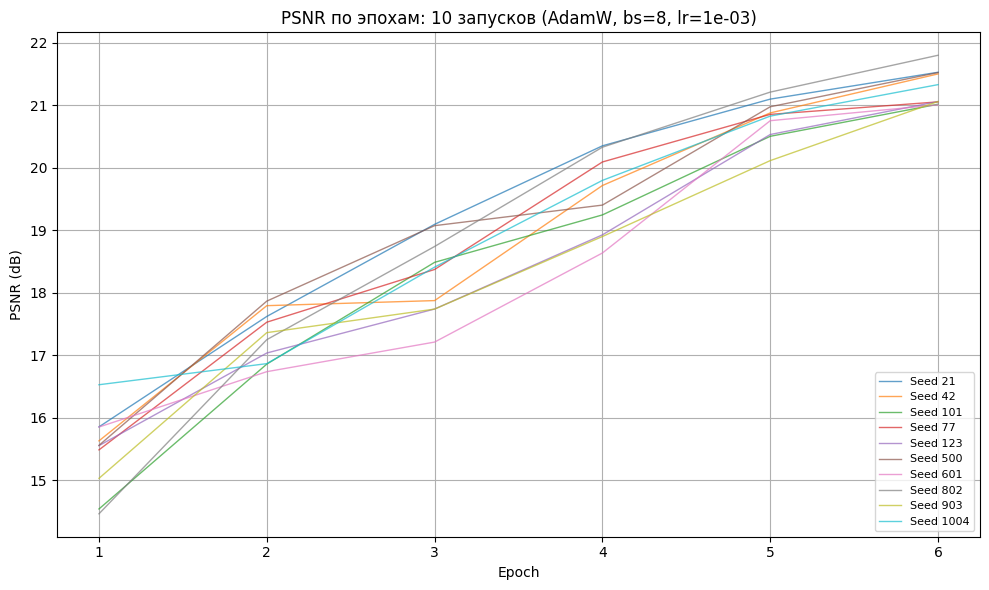

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

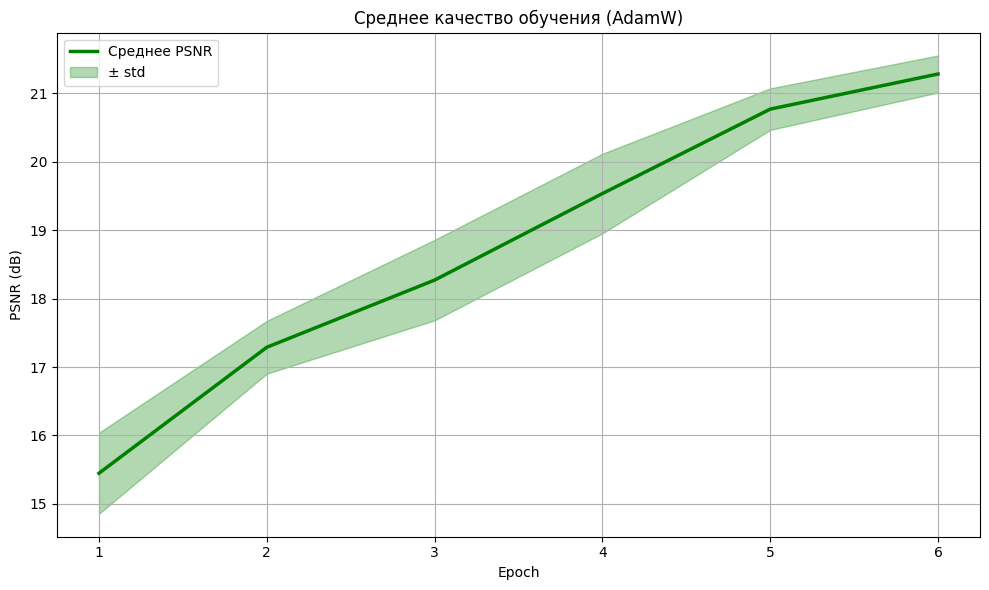

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

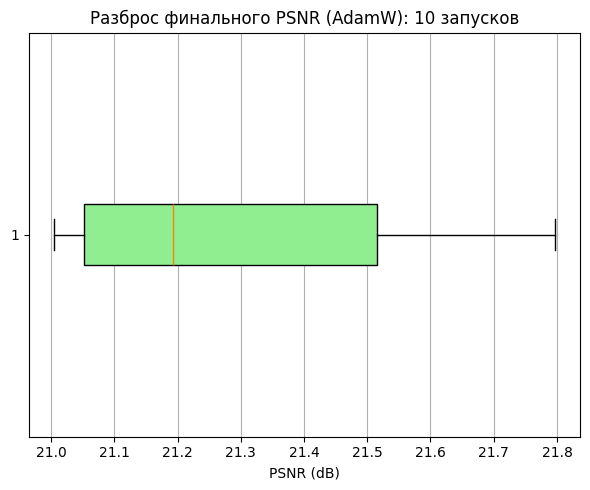


Эксперимент для AdamW завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## Adadelta


In [ ]:
OPTIMIZER_NAME = "Adadelta"

In [ ]:
OptimizerClass = torch.optim.Adadelta
opt_params_extra = {"rho": 0.9, "eps": 1e-6}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2789, PSNR: 5.94 dB
  [Эпоха 2/6] Loss: 0.2599, PSNR: 5.94 dB
  [Эпоха 3/6] Loss: 0.2909, PSNR: 5.94 dB
  [Эпоха 4/6] Loss: 0.2848, PSNR: 5.95 dB
  [Эпоха 5/6] Loss: 0.2773, PSNR: 5.95 dB
  [Эпоха 6/6] Loss: 0.2527, PSNR: 5.95 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 5.95 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.2045, PSNR: 5.96 dB
  [Эпоха 2/6] Loss: 0.2506, PSNR: 5.96 dB
  [Эпоха 3/6] Loss: 0.2930, PSNR: 5.96 dB
  [Эпоха 4/6] Loss: 0.2814, PSNR: 5.96 dB
  [Эпоха 5/6] Loss: 0.2382, PSNR: 5.97 dB
  [Эпоха 6/6] Loss: 0.2226, PSNR: 5.97 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 5.97 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2644, PSNR: 6.07 dB
  [Эпоха 2/6] Loss: 0.2567, PSNR: 6.07 dB
  [Эпоха 3/6] Loss: 0.2627, PSNR: 6.07 dB
  [Эпоха 4/6] Loss: 0.2514, PSNR: 6.07 dB
  [Эпоха 5/6] Loss: 0.2383, PSNR: 6.07 dB
  [Эпоха 6/6] Loss: 0.2485, PSNR: 6.07 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 6.07 dB

Запуск (BS=8, LR=1.0e-04, Seed=77)
  

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\n Все результаты сохранены в {search_results_filename}.")


 Все результаты сохранены в ALL_RESULTS_Adadelta_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (Adadelta): BS=8, LR=1e-03 → Средний PSNR = 6.08 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (Adadelta): PSNR = 6.13 ± 0.06 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


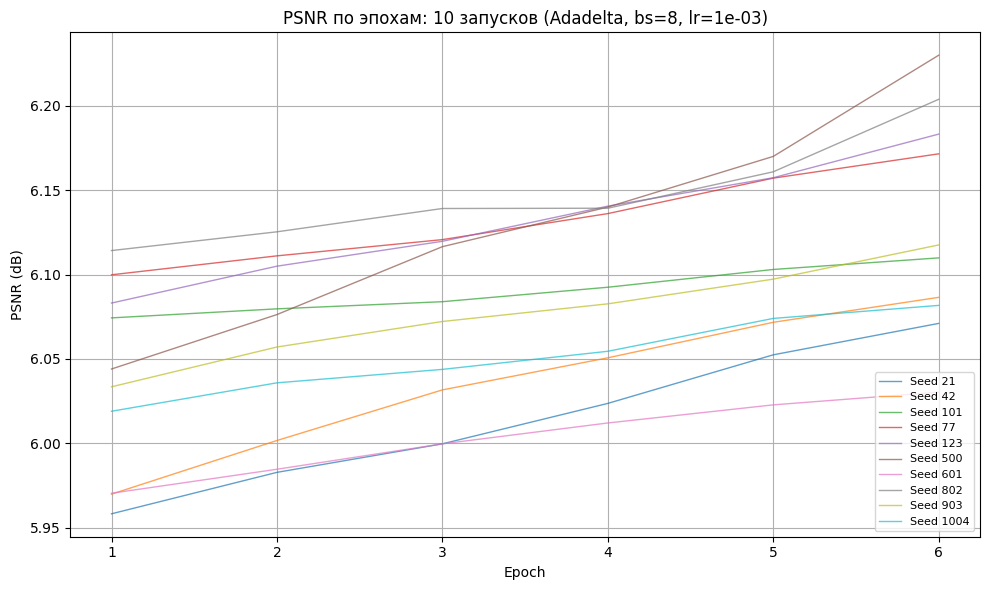

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

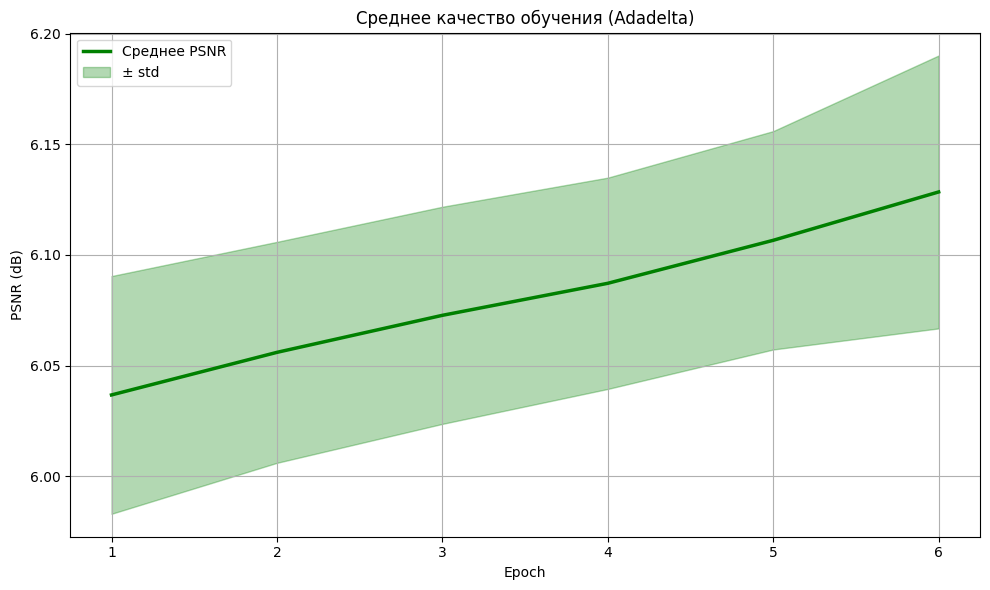

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

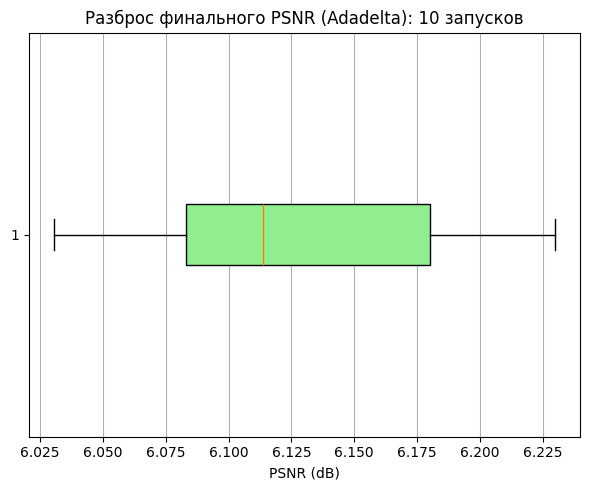


Эксперимент для Adadelta завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## Lion


In [ ]:
import torch
from torch.optim import Optimizer

class Lion(Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']
                beta1, beta2 = group['betas']
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)
                update = exp_avg.clone().sign_().mul_(group['lr'])
                p.add_(update, alpha=-1)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

        return loss

In [ ]:
OPTIMIZER_NAME = "Lion"

In [ ]:
OptimizerClass = Lion
opt_params_extra = {"betas": (0.9, 0.99), "weight_decay": 1e-4}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2560, PSNR: 6.94 dB
  [Эпоха 2/6] Loss: 0.1812, PSNR: 8.92 dB
  [Эпоха 3/6] Loss: 0.1149, PSNR: 12.23 dB
  [Эпоха 4/6] Loss: 0.0601, PSNR: 12.93 dB
  [Эпоха 5/6] Loss: 0.0354, PSNR: 16.52 dB
  [Эпоха 6/6] Loss: 0.0298, PSNR: 15.64 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 16.52 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.1911, PSNR: 6.78 dB
  [Эпоха 2/6] Loss: 0.1834, PSNR: 8.47 dB
  [Эпоха 3/6] Loss: 0.1332, PSNR: 11.70 dB
  [Эпоха 4/6] Loss: 0.0596, PSNR: 13.70 dB
  [Эпоха 5/6] Loss: 0.0338, PSNR: 16.69 dB
  [Эпоха 6/6] Loss: 0.0288, PSNR: 14.92 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 16.69 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2513, PSNR: 6.69 dB
  [Эпоха 2/6] Loss: 0.2039, PSNR: 8.16 dB
  [Эпоха 3/6] Loss: 0.1334, PSNR: 11.07 dB
  [Эпоха 4/6] Loss: 0.0688, PSNR: 12.30 dB
  [Эпоха 5/6] Loss: 0.0430, PSNR: 16.13 dB
  [Эпоха 6/6] Loss: 0.0297, PSNR: 15.39 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 16.13 dB

Запуск (BS=8, LR=1.0e-

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\n Все результаты сохранены в {search_results_filename}.")


 Все результаты сохранены в ALL_RESULTS_Lion_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (Lion): BS=8, LR=5e-04 → Средний PSNR = 12.14 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (Lion): PSNR = 13.89 ± 2.10 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


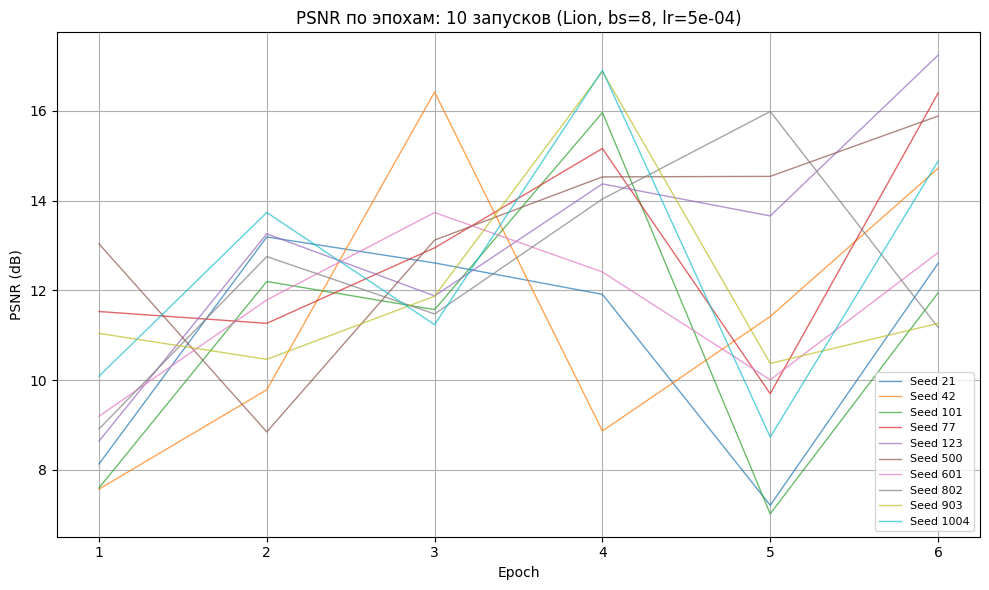

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

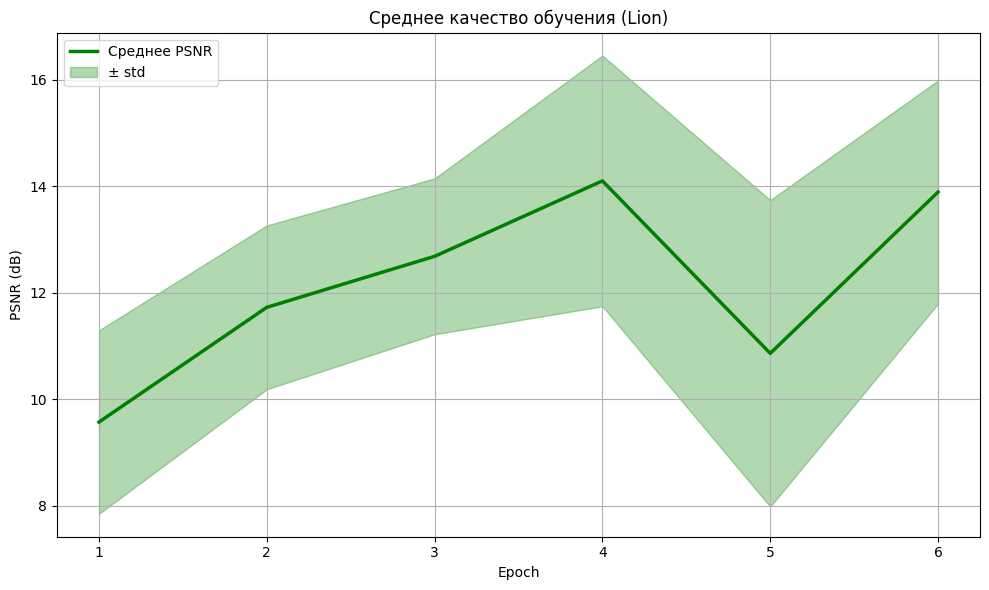

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

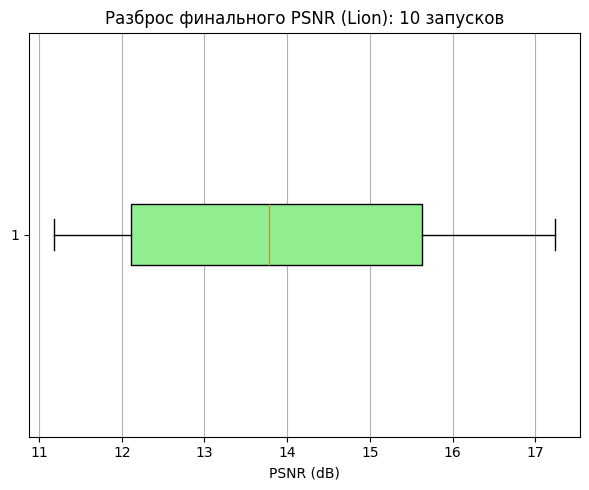


Эксперимент для Lion завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## SGD + Gradient Clipping - шумный


In [ ]:
class SGD_GCM(Optimizer):
    """
    SGD с momentum и градиентным клиппингом (как в статье GCM).
    """
    def __init__(self, params, lr=1e-3, momentum=0.9, clip_norm=1.0):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= momentum < 1.0:
            raise ValueError(f"Invalid momentum: {momentum}")
        if not 0.0 <= clip_norm:
            raise ValueError(f"Invalid clip norm: {clip_norm}")
        defaults = dict(lr=lr, momentum=momentum, clip_norm=clip_norm)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                torch.nn.utils.clip_grad_norm_([p], max_norm=group['clip_norm'])
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(p)

                buf = state['momentum_buffer']
                buf.mul_(group['momentum']).add_(grad)
                p.add_(buf, alpha=-group['lr'])
        return loss


In [ ]:
OPTIMIZER_NAME = "SGD_GCM"

In [ ]:

OptimizerClass = SGD_GCM
opt_params_extra = {"momentum": 0.9, "clip_norm": 1.0}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2787, PSNR: 5.96 dB
  [Эпоха 2/6] Loss: 0.2581, PSNR: 6.00 dB
  [Эпоха 3/6] Loss: 0.2863, PSNR: 6.05 dB
  [Эпоха 4/6] Loss: 0.2773, PSNR: 6.11 dB
  [Эпоха 5/6] Loss: 0.2673, PSNR: 6.15 dB
  [Эпоха 6/6] Loss: 0.2428, PSNR: 6.15 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 6.15 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.2042, PSNR: 5.99 dB
  [Эпоха 2/6] Loss: 0.2475, PSNR: 6.02 dB
  [Эпоха 3/6] Loss: 0.2888, PSNR: 6.05 dB
  [Эпоха 4/6] Loss: 0.2750, PSNR: 6.08 dB
  [Эпоха 5/6] Loss: 0.2316, PSNR: 6.11 dB
  [Эпоха 6/6] Loss: 0.2154, PSNR: 6.13 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 6.13 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2643, PSNR: 6.07 dB
  [Эпоха 2/6] Loss: 0.2561, PSNR: 6.09 dB
  [Эпоха 3/6] Loss: 0.2612, PSNR: 6.10 dB
  [Эпоха 4/6] Loss: 0.2496, PSNR: 6.11 dB
  [Эпоха 5/6] Loss: 0.2355, PSNR: 6.14 dB
  [Эпоха 6/6] Loss: 0.2443, PSNR: 6.17 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 6.17 dB

Запуск (BS=8, LR=1.0e-04, Seed=77)
  

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\n Все результаты сохранены в {search_results_filename}.")


 Все результаты сохранены в ALL_RESULTS_SGD_GCM_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (SGD_GCM): BS=8, LR=1e-03 → Средний PSNR = 7.38 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (SGD_GCM): PSNR = 9.43 ± 1.68 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


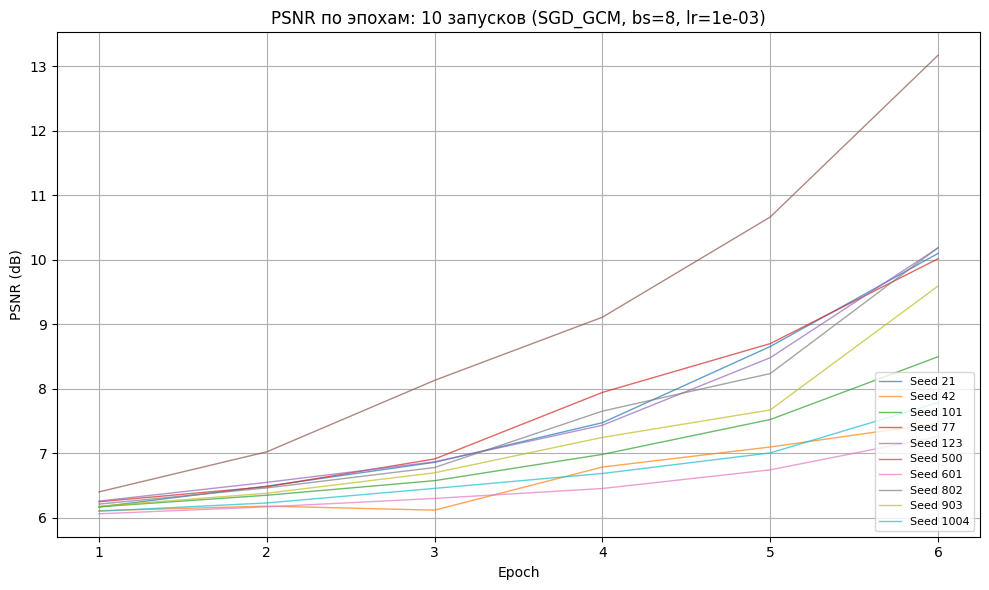

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

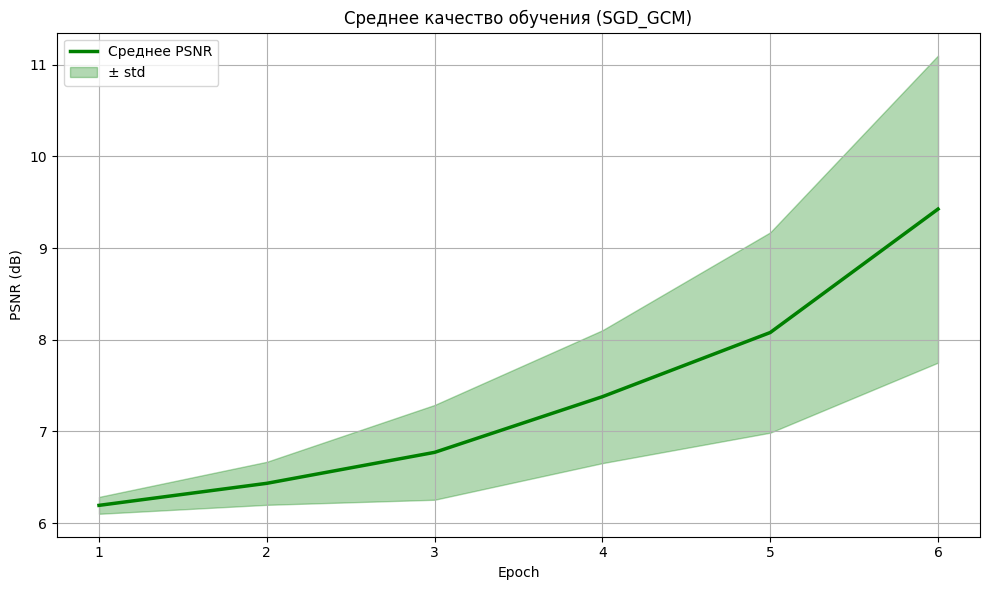

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

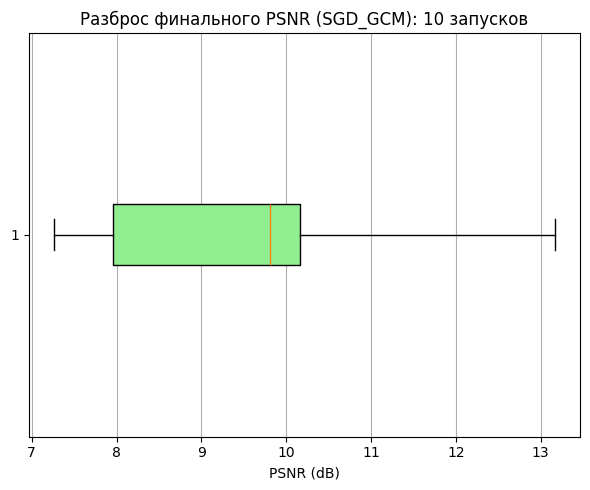


Эксперимент для SGD_GCM завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

## Adaptive Gradient Clipping - шумный


In [ ]:
class AGC_Optimizer(Optimizer):
    """
    Обёртка над SGD, применяющая Adaptive Gradient Clipping (AGC) из статьи.
    """
    def __init__(self, params, lr=1e-3, momentum=0.9, clip_factor=0.01, eps=1e-3):
        defaults = dict(lr=lr, momentum=momentum, clip_factor=clip_factor, eps=eps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]
                param_norm = p.data.norm().clamp(min=group['eps'])
                grad_norm = grad.norm().clamp(min=group['eps'])
                clip_coef = group['clip_factor'] * param_norm / (grad_norm + group['eps'])
                if clip_coef < 1:
                    grad = grad * clip_coef
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(p)

                buf = state['momentum_buffer']
                buf.mul_(group['momentum']).add_(grad)
                p.add_(buf, alpha=-group['lr'])

        return loss

In [ ]:
OPTIMIZER_NAME = "AGC_SGD"

In [ ]:
OptimizerClass = AGC_Optimizer
opt_params_extra = {"momentum": 0.9, "clip_factor": 0.01, "eps": 1e-3}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            result_dict = run_single_experiment(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=ESPCN_LSQ,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: PSNR = {result_dict['best_metric']:.2f} dB")


Запуск (BS=8, LR=1.0e-04, Seed=21)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [Эпоха 1/6] Loss: 0.2788, PSNR: 5.94 dB
  [Эпоха 2/6] Loss: 0.2597, PSNR: 5.95 dB
  [Эпоха 3/6] Loss: 0.2904, PSNR: 5.96 dB
  [Эпоха 4/6] Loss: 0.2840, PSNR: 5.96 dB
  [Эпоха 5/6] Loss: 0.2762, PSNR: 5.97 dB
  [Эпоха 6/6] Loss: 0.2516, PSNR: 5.98 dB
  > BS=8, LR=1e-04, Seed=21: PSNR = 5.98 dB

Запуск (BS=8, LR=1.0e-04, Seed=42)
  [Эпоха 1/6] Loss: 0.2043, PSNR: 5.96 dB
  [Эпоха 2/6] Loss: 0.2501, PSNR: 5.97 dB
  [Эпоха 3/6] Loss: 0.2925, PSNR: 5.97 dB
  [Эпоха 4/6] Loss: 0.2807, PSNR: 5.98 dB
  [Эпоха 5/6] Loss: 0.2374, PSNR: 5.98 dB
  [Эпоха 6/6] Loss: 0.2219, PSNR: 5.99 dB
  > BS=8, LR=1e-04, Seed=42: PSNR = 5.99 dB

Запуск (BS=8, LR=1.0e-04, Seed=101)
  [Эпоха 1/6] Loss: 0.2643, PSNR: 6.07 dB
  [Эпоха 2/6] Loss: 0.2566, PSNR: 6.08 dB
  [Эпоха 3/6] Loss: 0.2624, PSNR: 6.08 dB
  [Эпоха 4/6] Loss: 0.2509, PSNR: 6.08 dB
  [Эпоха 5/6] Loss: 0.2376, PSNR: 6.09 dB
  [Эпоха 6/6] Loss: 0.2476, PSNR: 6.09 dB
  > BS=8, LR=1e-04, Seed=101: PSNR = 6.09 dB

Запуск (BS=8, LR=1.0e-04, Seed=77)
  

In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\n Все результаты сохранены в {search_results_filename}.")


 Все результаты сохранены в ALL_RESULTS_AGC_SGD_full.json.


In [ ]:
from collections import defaultdict

config_stats = defaultdict(list)

for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), psnrs in config_stats.items():
    if len(psnrs) == len(SEEDS):
        avg_psnr = np.mean(psnrs)
        if avg_psnr > best_mean:
            best_mean = avg_psnr
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"\nЛУЧШАЯ КОНФИГУРАЦИЯ ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средний PSNR = {best_mean:.2f} dB")


ЛУЧШАЯ КОНФИГУРАЦИЯ (AGC_SGD): BS=8, LR=1e-03 → Средний PSNR = 6.16 dB


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_psnrs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_psnrs_full)
std_final = np.std(final_psnrs_full)

print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ ({OPTIMIZER_NAME}): PSNR = {mean_final:.2f} ± {std_final:.2f} dB")



ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (AGC_SGD): PSNR = 6.27 ± 0.08 dB


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_psnr_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_psnr_final_epoch": float(mean_final),
        "std_psnr_final_epoch": float(std_final),
        "all_final_psnrs": [float(p) for p in final_psnrs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)


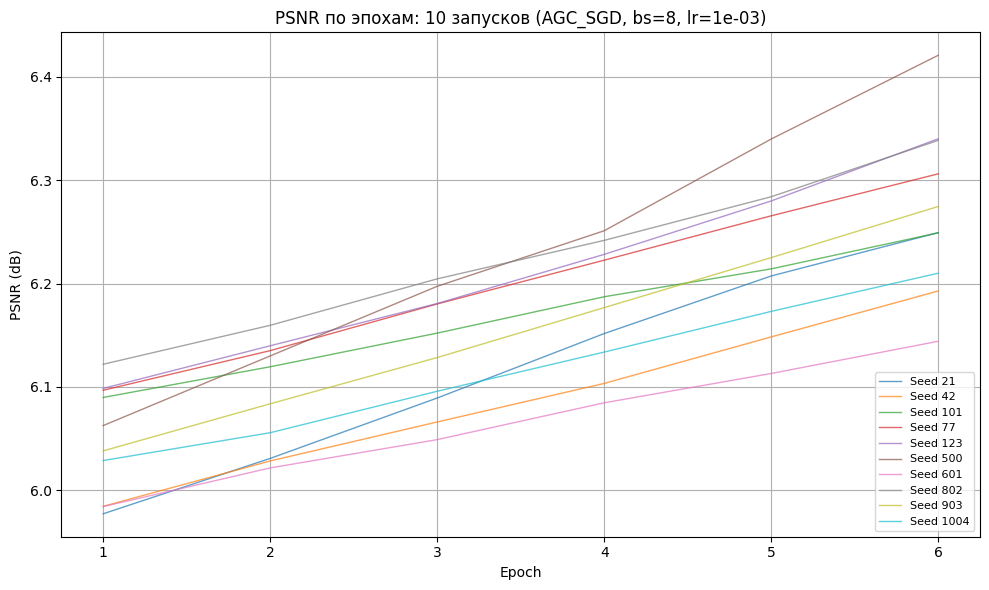

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'PSNR по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_psnr.png"), dpi=150)
plt.show()

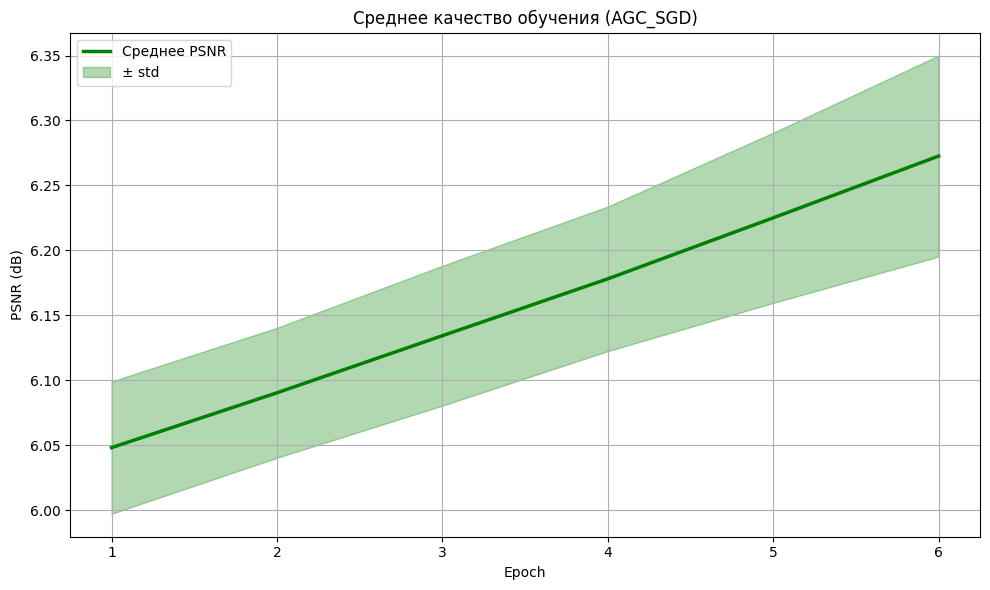

In [ ]:
all_psnr_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_psnr = np.mean(all_psnr_curves, axis=0)
std_psnr = np.std(all_psnr_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_psnr) + 1)
plt.plot(epochs, mean_psnr, color='green', linewidth=2.5, label='Среднее PSNR')
plt.fill_between(epochs, mean_psnr - std_psnr, mean_psnr + std_psnr, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_psnr.png"), dpi=150)
plt.show()

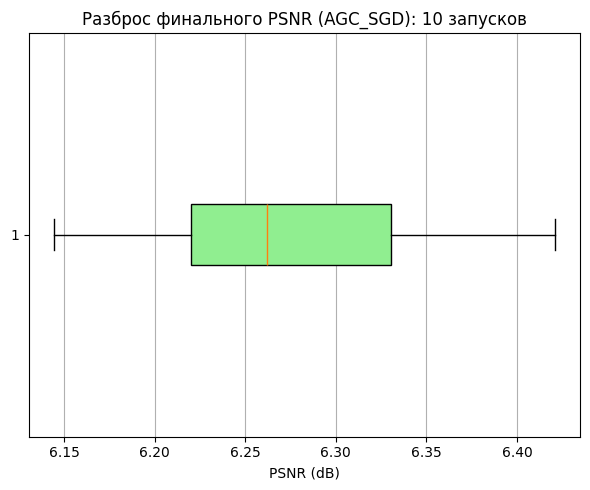


Эксперимент для AGC_SGD завершён.


In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_psnrs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('PSNR (dB)')
plt.title(f'Разброс финального PSNR ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_psnr_boxplot.png"), dpi=150)
plt.show()

print(f"\nЭксперимент для {OPTIMIZER_NAME} завершён.")

# Итоговый результат

In [ ]:
import json
import os
import pandas as pd

results_dir = "/content/result"

all_runs = []
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        with open(os.path.join(results_dir, filename), "r") as f:
            data = json.load(f)
            if isinstance(data, list):
                all_runs.extend(data)
            else:
                all_runs.append(data)
df = pd.DataFrame(all_runs)
df.head()

,run_id,task_name,model_name,optimizer,batch_size,learning_rate,epochs,seed,log_file_path,mean_metric_all_epochs,best_metric,best_epoch,final_metric,total_time_sec,metric_history,loss_history
0,68adc1eb-9f09-454e-97c9-c1731786ad81,SuperResolution,ESPCN_LSQ,Adadelta,8,0.0001,6,21,/content/drive/MyDrive/SR_ESPCN_LSQ_Experiment...,5.946829,5.954916,6,5.954916,111.64,"[5.9408684253692625, 5.941639184951782, 5.9441...","[0.27893423914909365, 0.25993363857269286, 0.2..."
1,067ff3c8-5a41-4dda-a84b-ac4ec2767bd5,SuperResolution,ESPCN_LSQ,Adadelta,8,0.0001,6,42,/content/drive/MyDrive/SR_ESPCN_LSQ_Experiment...,5.962033,5.968715,6,5.968715,111.53,"[5.956801795959473, 5.957018804550171, 5.96172...","[0.20446520388126374, 0.25057346940040587, 0.2..."
2,66c2e694-92f7-48d2-b9dc-1b18696d953d,SuperResolution,ESPCN_LSQ,Adadelta,8,0.0001,6,101,/content/drive/MyDrive/SR_ESPCN_LSQ_Experiment...,6.072016,6.073592,2,6.070971,111.44,"[6.07001576423645, 6.073591947555542, 6.072979...","[0.264355331659317, 0.2567492002248764, 0.2626..."
3,b15fb0ca-39d2-4cd0-b600-21a9728c526d,SuperResolution,ESPCN_LSQ,Adadelta,8,0.0001,6,77,/content/drive/MyDrive/SR_ESPCN_LSQ_Experiment...,6.083793,6.088832,5,6.087878,114.19,"[6.078033018112182, 6.0804259300231935, 6.0824...","[0.271193813085556, 0.24905662178993226, 0.260..."
4,b81483a4-5f01-415f-85cf-6816d95e74ac,SuperResolution,ESPCN_LSQ,Adadelta,8,0.0001,6,123,/content/drive/MyDrive/SR_ESPCN_LSQ_Experiment...,6.072273,6.074399,4,6.073979,119.55,"[6.069210815429687, 6.068673992156983, 6.07409...","[0.24122609615325927, 0.24430722177028655, 0.2..."


In [ ]:
summary = df.groupby(['optimizer', 'batch_size', 'learning_rate'])['final_metric'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    median='median',
    count='count'
).round(3).reset_index()


summary = summary.sort_values('mean', ascending=False)
summary

,optimizer,batch_size,learning_rate,mean,std,min,max,median,count
20,Adam,8,0.0010,21.338,0.311,20.905,21.676,21.325,10
26,AdamW,8,0.0010,21.285,0.285,21.004,21.797,21.192,10
19,Adam,8,0.0005,20.444,0.421,19.549,20.882,20.609,10
25,AdamW,8,0.0005,20.407,0.533,19.372,20.922,20.616,10
42,RMSprop,8,0.0001,19.966,0.328,19.581,20.585,19.849,10
8,AdaGrad,8,0.0010,19.735,0.503,18.874,20.365,19.748,10
29,AdamW,16,0.0010,18.935,0.798,17.899,20.278,18.836,10
23,Adam,16,0.0010,18.923,0.795,17.850,20.245,18.832,10
45,RMSprop,16,0.0001,18.817,0.518,17.867,19.581,18.945,10
11,AdaGrad,16,0.0010,18.696,0.567,17.799,19.591,18.675,10


In [ ]:
best_per_optimizer = df.groupby('optimizer')['final_metric'].max().sort_values(ascending=False)
best_per_optimizer

,final_metric
optimizer,
AdamW,21.796817
Adam,21.676157
RMSprop,21.321124
AdaGrad,20.365104
Lion,17.747864
Nesterov,14.259761
SGD_GCM,13.168402
SGD,13.168402
AGC_SGD,6.420986


In [ ]:
idx_best = df.groupby('optimizer')['final_metric'].idxmax()
df.loc[idx_best, ['optimizer', 'batch_size', 'learning_rate', 'final_metric']].sort_values('final_metric', ascending=False)

,optimizer,batch_size,learning_rate,final_metric
507,AdamW,8,0.0010,21.796817
267,Adam,8,0.0010,21.676157
377,RMSprop,8,0.0005,21.321124
441,AdaGrad,8,0.0010,20.365104
125,Lion,8,0.0001,17.747864
205,Nesterov,8,0.0010,14.259761
85,SGD_GCM,8,0.0010,13.168402
565,SGD,8,0.0010,13.168402
325,AGC_SGD,8,0.0010,6.420986
25,Adadelta,8,0.0010,6.229823
